In [1]:
# Import basic libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import OrderedDict

# Import PyTorch
import torch # import main library
from torch.autograd import Variable
import torch.nn as nn # import modules
from torch.autograd import Function # import Function to create custom activations
from torch.nn.parameter import Parameter # import Parameter to create custom activations with learnable parameters
from torch import optim # import optimizers for demonstrations
import torch.nn.functional as F # import torch functions
from torchvision import datasets, transforms # import transformations to use for demo
from torch.nn.parameter import Parameter # import Parameter to create custom activations with learnable parameters

from models.activ_func import *
from models.Nets import *
from models.test import test_img
from models.Update import *


from utils.sampling import mnist_iid, mnist_noniid, cifar_iid
from utils.options import args_parser
from models.Update import LocalUpdate
from models.Nets import *
from models.Fed import FedAvg
from models.Fed import FedQAvg, Quantization, Quantization_Finite, my_score, my_score_Finite
from models.test import test_img
from torch.utils.data import DataLoader, Dataset
from utils.functions import *

import torchvision

import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
class my_argument:    
    epochs    = 16    #"rounds of training"
    num_users = 2  # "number of users: K"
    frac      = 0.5 #"the fraction of clients: C"
    local_ep  = 1 #"the number of local epochs: E"
    local_bs  = 50  #"local batch size: B"
    bs        = 50 #"test batch size"
    lr        = 0.001 #"learning rate"
    momentum  = 0.5 # "SGD momentum (default: 0.5)"
    weight_decay = 5e-4
    split     = 'user' # "train-test split type, user or sample"
    opt='ADAM'
    loss='Custom' # 'Custom' or 'Default'

    # model arguments
    model = 'cnn'
    kernel_num=9 #, help='number of each kind of kernel')
    kernel_sizes='3,4,5' #  help='comma-separated kernel size to use for convolution')
    norm='batch_norm' #, help="batch_norm, layer_norm, or None")
    num_filters=32 #, help="number of filters for conv nets")
    max_pool='True' #help="Whether use max pooling rather than strided convolutions")

    # other arguments
    dataset='cifar' #, help="name of dataset")
    iid=1
    num_classes=10#, help="number of classes")
    num_channels=1#, help="number of channels of imges")
    gpu=1#, help="GPU ID, -1 for CPU")
    stopping_rounds=10#, help='rounds of early stopping')
    verbose='False'#, help='verbose print')
    seed=1#, help='random seed (default: 1)')
    
args = my_argument()

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

use_cuda = torch.cuda.is_available()
print(use_cuda)
args.device = torch.device("cuda" if use_cuda else "cpu")
print(args.device)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# trainset = torchvision.datasets.CIFAR10(
#     root="./data/cifar", train=True, download=True, transform=transform_train)
# trainloader = torch.utils.data.DataLoader(
#     trainset, batch_size=args.bs, shuffle=True, num_workers=2)

# testset = torchvision.datasets.CIFAR10(
#     root="./data/cifar", train=False, download=True, transform=transform_test)
# testloader = torch.utils.data.DataLoader(
#     testset, batch_size=args.bs, shuffle=False, num_workers=2)

dataset_train = datasets.CIFAR10('../data/cifar', train=True, download=True, transform=transform_train)
dataset_test = datasets.CIFAR10('../data/cifar', train=False, download=True, transform=transform_test)
if args.iid:
    dict_users = cifar_iid(dataset_train, args.num_users)

True
cuda
Files already downloaded and verified
Files already downloaded and verified


In [3]:
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    for images, labels in testloader:

#         images.resize_(images.shape[0], 3*32*32)

        images = images.cuda()
        labels = labels.cuda()

        output = model.forward(images)
        test_loss += criterion(output, labels).item()

        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()

    return test_loss, accuracy

# BACC encoding (K=2)

In [4]:
encoding_input_array_np = np.empty((len(dataset_train),32*32*3))
encoding_label_array_np = np.empty((len(dataset_train),args.num_classes))
print("size of X:" ,encoding_input_array_np.shape)
print("size of Y:" ,encoding_label_array_np.shape)

Size_submatrices = int(50000/args.num_users)


for i in range(args.num_users):
    
    stt_pos = i*Size_submatrices
    end_pos = (i+1)*Size_submatrices
#     print(i,stt_pos,end_pos)
    Temp_train = DataLoader(DatasetSplit(dataset_train, dict_users[i]), batch_size=Size_submatrices, shuffle=True)
    
    for batch_idx, (images, labels) in enumerate(Temp_train):
        
        images_np = images.detach().cpu().numpy()
        
#         print(np.size(images_np))
        encoding_input_array_np[stt_pos:end_pos,:] = np.reshape(images_np, (Size_submatrices,32*32*3))
#         print(encoding_input_array_np[stt_pos:end_pos,:].shape)

        onehot_labels = torch.nn.functional.one_hot(labels,num_classes=args.num_classes)
        labels_np = onehot_labels.detach().cpu().numpy()
#         print(labels_np.shape)
        encoding_label_array_np[stt_pos:end_pos,:] = labels_np
    
print(np.shape(encoding_label_array_np))

avg_power = np.sum(encoding_input_array_np*encoding_input_array_np, axis=1)/np.shape(encoding_input_array_np)[1]
avg_power = np.sum(avg_power)/np.shape(encoding_input_array_np)[0]
print(avg_power)

size of X: (50000, 3072)
size of Y: (50000, 10)
(50000, 10)
2.0739268680593934


In [19]:
N = 2
K = 2
T = 3
sigma = 0.1
Noise_Alloc = [0,2,4]

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


z_array = np.array([-0.81, 0.81])
j_array = np.array(range(K+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))

_Noise_label = np.ones((25000*T,10)) * 0.1

X_tilde,a,b = BACC_Enc_Data_v3(encoding_input_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
y_tilde,a,b = BACC_Enc_Data_v3(encoding_label_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)


@BACC_Enc: N,K,T, m_i= 2 2 3 25000 

@BACC_Enc: N,K,T, m_i= 2 2 3 25000 



In [58]:
_net = ResNet18()

net_tmp = copy.deepcopy(_net)
w_tmp = net_tmp.state_dict()

for k in w_tmp.keys():
    print(k)

conv1.weight
bn1.weight
bn1.bias
bn1.running_mean
bn1.running_var
bn1.num_batches_tracked
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.bn1.running_mean
layer1.0.bn1.running_var
layer1.0.bn1.num_batches_tracked
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.bn2.running_mean
layer1.0.bn2.running_var
layer1.0.bn2.num_batches_tracked
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.bn1.running_mean
layer1.1.bn1.running_var
layer1.1.bn1.num_batches_tracked
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.bn2.running_mean
layer1.1.bn2.running_var
layer1.1.bn2.num_batches_tracked
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.bn1.running_mean
layer2.0.bn1.running_var
layer2.0.bn1.num_batches_tracked
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.bn2.running_mean
layer2.0.bn2.running_var
layer2.0.bn2.num_batches_tracked
layer2.0.shortcut.0.weight
layer2.0.shortcut.1

In [29]:
iter = 0
power_array = []
for iter in range(50):
    print('iter=',iter)
    _net = ResNet18()
    PATH = "./save_models/CIFAR10_ResNet18_K2_G1_T3_E50_inPowerAlign_iter"+str(iter)+".pt"
    _net.load_state_dict(torch.load(PATH))

    net_tmp = copy.deepcopy(_net)
    w_tmp = net_tmp.state_dict()

    tmp_power_array = []
    for k in w_tmp.keys():
        tmp1 = w_tmp[k].cpu().detach().numpy()
        cur_shape = tmp1.shape
        _d = np.prod(cur_shape).astype('int')

        #print(k,_d,cur_shape)

        _w_cur = np.reshape(tmp1,(1,_d))
        _cur_power = np.sum(_w_cur * _w_cur) / _d

        if k=='conv1.weight' or k=='layer1.0.conv1.weight' or  k=='layer1.1.conv1.weight' or k=='layer2.0.conv1.weight' or k=='layer2.1.conv1.weight'or k=='layer3.0.conv1.weight' or  k=='layer3.1.conv1.weight'or k=='layer4.0.conv1.weight' or  k=='layer4.1.conv1.weight' or k=='linear.weight':
            tmp_power_array.append(_cur_power)
            print(k,_cur_power)
#     print(tmp_power_array)
    power_array.append(tmp_power_array)
    print()
    print()

power_array_BACC_K2_N2_noPowerAlign = np.array(power_array)

iter= 0
conv1.weight 0.012327810128529867
layer1.0.conv1.weight 0.0005757373550699817
layer1.1.conv1.weight 0.0005789981223642826
layer2.0.conv1.weight 0.0005715031487246355
layer2.1.conv1.weight 0.00028688434718383686
layer3.0.conv1.weight 0.00028493527012566727
layer3.1.conv1.weight 0.0001419184005094899
layer4.0.conv1.weight 0.00013941891180972257
layer4.1.conv1.weight 6.875466917537981e-05
linear.weight 0.000625896267592907


iter= 1
conv1.weight 0.012294940374515674
layer1.0.conv1.weight 0.0005747215925819344
layer1.1.conv1.weight 0.0005769915361371306
layer2.0.conv1.weight 0.0005675115519099765
layer2.1.conv1.weight 0.00028457728007601365
layer3.0.conv1.weight 0.0002805416265295611
layer3.1.conv1.weight 0.0001394921111770802
layer4.0.conv1.weight 0.0001343011131717099
layer4.1.conv1.weight 6.478638776267569e-05
linear.weight 0.000625310419127345


iter= 2
conv1.weight 0.012274753164362025
layer1.0.conv1.weight 0.0005746419645018048
layer1.1.conv1.weight 0.0005762755042976803
laye

conv1.weight 0.011737387489389491
layer1.0.conv1.weight 0.0005584248962501684
layer1.1.conv1.weight 0.0005450392555859354
layer2.0.conv1.weight 0.0005054961786501937
layer2.1.conv1.weight 0.0002500397256679005
layer3.0.conv1.weight 0.0002215593121945858
layer3.1.conv1.weight 0.00010818945399175088
layer4.0.conv1.weight 8.289543135712545e-05
layer4.1.conv1.weight 1.624946081493464e-05
linear.weight 0.0006698678247630596


iter= 20
conv1.weight 0.011691962127332334
layer1.0.conv1.weight 0.0005565616302192211
layer1.1.conv1.weight 0.0005420119398170047
layer2.0.conv1.weight 0.0005003923239807287
layer2.1.conv1.weight 0.00024710150642527477
layer3.0.conv1.weight 0.00021730774703125158
layer3.1.conv1.weight 0.00010585455068697532
layer4.0.conv1.weight 7.994492383052905e-05
layer4.1.conv1.weight 1.4563889837720328e-05
linear.weight 0.0006784744560718537


iter= 21
conv1.weight 0.011646727720896402
layer1.0.conv1.weight 0.0005547270282275147
layer1.1.conv1.weight 0.0005390558184848891
layer2.

conv1.weight 0.01091488864686754
layer1.0.conv1.weight 0.0005246738696263896
layer1.1.conv1.weight 0.000491983981596099
layer2.0.conv1.weight 0.0004221495861808459
layer2.1.conv1.weight 0.00020356500883483223
layer3.0.conv1.weight 0.000161033615262972
layer3.1.conv1.weight 7.630559331220057e-05
layer4.0.conv1.weight 4.80977145748006e-05
layer4.1.conv1.weight 4.1032961032922485e-06
linear.weight 0.000882662832736969


iter= 39
conv1.weight 0.01087201303905911
layer1.0.conv1.weight 0.0005229454384081893
layer1.1.conv1.weight 0.0004893221581975619
layer2.0.conv1.weight 0.00041829623902837437
layer2.1.conv1.weight 0.00020149285491142009
layer3.0.conv1.weight 0.00015865033492445946
layer3.1.conv1.weight 7.51064960948295e-05
layer4.0.conv1.weight 4.7011226544984514e-05
layer4.1.conv1.weight 3.921429904746927e-06
linear.weight 0.0008959498256444931


iter= 40
conv1.weight 0.010831035949565746
layer1.0.conv1.weight 0.0005212646081215806
layer1.1.conv1.weight 0.00048679811879992485
layer2.0.con

In [30]:
iter = 0
power_array = []
for iter in range(50):
    print('iter=',iter)
    _net = ResNet18()
    PATH = "./save_models/CIFAR10_ResNet18_K2_G1_T3_E50_iter"+str(iter)+".pt"
    _net.load_state_dict(torch.load(PATH))

    net_tmp = copy.deepcopy(_net)
    w_tmp = net_tmp.state_dict()

    tmp_power_array = []
    for k in w_tmp.keys():
        tmp1 = w_tmp[k].cpu().detach().numpy()
        cur_shape = tmp1.shape
        _d = np.prod(cur_shape).astype('int')

        #print(k,_d,cur_shape)

        _w_cur = np.reshape(tmp1,(1,_d))
        _cur_power = np.sum(_w_cur * _w_cur) / _d

        if k=='conv1.weight' or k=='layer1.0.conv1.weight' or  k=='layer1.1.conv1.weight' or k=='layer2.0.conv1.weight' or k=='layer2.1.conv1.weight'or k=='layer3.0.conv1.weight' or  k=='layer3.1.conv1.weight'or k=='layer4.0.conv1.weight' or  k=='layer4.1.conv1.weight' or k=='linear.weight':
            tmp_power_array.append(_cur_power)
            print(k,_cur_power)
#     print(tmp_power_array)
    power_array.append(tmp_power_array)
    print()
    print()

power_array_BACC_K2_N2_inPowerAlign = np.array(power_array)

iter= 0
conv1.weight 0.01219057043393453
layer1.0.conv1.weight 0.0005824484655426608
layer1.1.conv1.weight 0.0005793276553352674
layer2.0.conv1.weight 0.0005721869981951184
layer2.1.conv1.weight 0.00028800941072404385
layer3.0.conv1.weight 0.0002854387793276045
layer3.1.conv1.weight 0.00014197545695222088
layer4.0.conv1.weight 0.00013954211802532276
layer4.1.conv1.weight 6.886490801763203e-05
linear.weight 0.0006419276818633079


iter= 1
conv1.weight 0.012155828652558502
layer1.0.conv1.weight 0.0005812719464302063
layer1.1.conv1.weight 0.0005772014976375633
layer2.0.conv1.weight 0.0005679931491613388
layer2.1.conv1.weight 0.0002856813371181488
layer3.0.conv1.weight 0.00028088572435081005
layer3.1.conv1.weight 0.00013942358135763142
layer4.0.conv1.weight 0.0001342695646194948
layer4.1.conv1.weight 6.484447900826733e-05
linear.weight 0.0006412548944354057


iter= 2
conv1.weight 0.01213577941611961
layer1.0.conv1.weight 0.0005811038427054882
layer1.1.conv1.weight 0.0005764776530365149
lay

conv1.weight 0.011585179302427504
layer1.0.conv1.weight 0.0005631571014722189
layer1.1.conv1.weight 0.0005447095673945215
layer2.0.conv1.weight 0.0005051078688767222
layer2.1.conv1.weight 0.00025160121731460094
layer3.0.conv1.weight 0.00022128051043384604
layer3.1.conv1.weight 0.00010779126831847761
layer4.0.conv1.weight 8.259092121281558e-05
layer4.1.conv1.weight 1.6625634291105802e-05
linear.weight 0.0006799220107495784


iter= 20
conv1.weight 0.011538864285857589
layer1.0.conv1.weight 0.0005611390289333132
layer1.1.conv1.weight 0.0005416377551025815
layer2.0.conv1.weight 0.0005000030311445395
layer2.1.conv1.weight 0.00024871603171858523
layer3.0.conv1.weight 0.0002170351023475329
layer3.1.conv1.weight 0.00010548283009686404
layer4.0.conv1.weight 7.96645633979804e-05
layer4.1.conv1.weight 1.4854999284984337e-05
linear.weight 0.0006878347136080265


iter= 21
conv1.weight 0.011492197160367612
layer1.0.conv1.weight 0.0005591927717129389
layer1.1.conv1.weight 0.0005386446913083395
layer2

conv1.weight 0.010744350927847403
layer1.0.conv1.weight 0.0005264390363461442
layer1.1.conv1.weight 0.0004907180037763384
layer2.0.conv1.weight 0.0004207379339883725
layer2.1.conv1.weight 0.00020531888326836957
layer3.0.conv1.weight 0.0001602058893897467
layer3.1.conv1.weight 7.575613886324895e-05
layer4.0.conv1.weight 4.7697132686153054e-05
layer4.1.conv1.weight 4.18755371356383e-06
linear.weight 0.000879796501249075


iter= 39
conv1.weight 0.010703114447770294
layer1.0.conv1.weight 0.0005246606758899159
layer1.1.conv1.weight 0.0004881612646083037
layer2.0.conv1.weight 0.00041702508719431027
layer2.1.conv1.weight 0.00020336420533971654
layer3.0.conv1.weight 0.0001579515196176039
layer3.1.conv1.weight 7.462390284571383e-05
layer4.0.conv1.weight 4.6676985220983624e-05
layer4.1.conv1.weight 3.990293609806233e-06
linear.weight 0.000892031379044056


iter= 40
conv1.weight 0.010662589912061338
layer1.0.conv1.weight 0.0005228029977944163
layer1.1.conv1.weight 0.00048550575350721675
layer2.0.

In [31]:
iter = 0
power_array = []
for iter in range(50):
    print('iter=',iter)
    _net = ResNet18()
    PATH = "./save_models/CIFAR10_ResNet18_K2_Plain_E50_iter"+str(iter)+".pt"
    _net.load_state_dict(torch.load(PATH))

    net_tmp = copy.deepcopy(_net)
    w_tmp = net_tmp.state_dict()

    tmp_power_array = []
    for k in w_tmp.keys():
        tmp1 = w_tmp[k].cpu().detach().numpy()
        cur_shape = tmp1.shape
        _d = np.prod(cur_shape).astype('int')

        #print(k,_d,cur_shape)

        _w_cur = np.reshape(tmp1,(1,_d))
        _cur_power = np.sum(_w_cur * _w_cur) / _d

        if k=='conv1.weight' or k=='layer1.0.conv1.weight' or  k=='layer1.1.conv1.weight' or k=='layer2.0.conv1.weight' or k=='layer2.1.conv1.weight'or k=='layer3.0.conv1.weight' or  k=='layer3.1.conv1.weight'or k=='layer4.0.conv1.weight' or  k=='layer4.1.conv1.weight' or k=='linear.weight':
            tmp_power_array.append(_cur_power)
            print(k,_cur_power)
#     print(tmp_power_array)
    power_array.append(tmp_power_array)
    print()
    print()

power_array_Plain_K2 = np.array(power_array)

iter= 0
conv1.weight 0.012232985761430528
layer1.0.conv1.weight 0.0005767999423874749
layer1.1.conv1.weight 0.0005812099617388514
layer2.0.conv1.weight 0.0005759965214464399
layer2.1.conv1.weight 0.000288671710424953
layer3.0.conv1.weight 0.0002881259036560853
layer3.1.conv1.weight 0.00014422993020464978
layer4.0.conv1.weight 0.00014306923064092794
layer4.1.conv1.weight 7.13718731680678e-05
linear.weight 0.0006576091051101685


iter= 1
conv1.weight 0.01221793669241446
layer1.0.conv1.weight 0.0005774604053133064
layer1.1.conv1.weight 0.0005814443445867962
layer2.0.conv1.weight 0.000575494228137864
layer2.1.conv1.weight 0.00028856145218014717
layer3.0.conv1.weight 0.0002872027301539977
layer3.1.conv1.weight 0.00014379914177374708
layer4.0.conv1.weight 0.00014146960650881132
layer4.1.conv1.weight 7.001527248778277e-05
linear.weight 0.0006623374298214913


iter= 2
conv1.weight 0.012201820258741026
layer1.0.conv1.weight 0.0005781570863392618
layer1.1.conv1.weight 0.0005816914555099276
layer

conv1.weight 0.011978989398037945
layer1.0.conv1.weight 0.0005873828712436887
layer1.1.conv1.weight 0.0005815126933157444
layer2.0.conv1.weight 0.0005584486449758211
layer2.1.conv1.weight 0.0002831155951652262
layer3.0.conv1.weight 0.0002676050903068648
layer3.1.conv1.weight 0.0001374148867196507
layer4.0.conv1.weight 0.00011593728171040614
layer4.1.conv1.weight 4.2488284331435956e-05
linear.weight 0.0010667804628610611


iter= 20
conv1.weight 0.011967087233508075
layer1.0.conv1.weight 0.0005876645445823669
layer1.1.conv1.weight 0.0005813334654602739
layer2.0.conv1.weight 0.0005573289882805613
layer2.1.conv1.weight 0.0002827228357394536
layer3.0.conv1.weight 0.00026656317317651375
layer3.1.conv1.weight 0.00013719365880307223
layer4.0.conv1.weight 0.00011477402100960414
layer4.1.conv1.weight 4.138163704839018e-05
linear.weight 0.001103712897747755


iter= 21
conv1.weight 0.011954609994535093
layer1.0.conv1.weight 0.0005880810527337922
layer1.1.conv1.weight 0.000581191231807073
layer2.0.

conv1.weight 0.011734113649085717
layer1.0.conv1.weight 0.0005908198654651642
layer1.1.conv1.weight 0.0005769483331176969
layer2.0.conv1.weight 0.0005350555810663435
layer2.1.conv1.weight 0.00027558851676682633
layer3.0.conv1.weight 0.0002490715899815162
layer3.1.conv1.weight 0.0001349235988325543
layer4.0.conv1.weight 9.640909653777878e-05
layer4.1.conv1.weight 2.708755912155741e-05
linear.weight 0.0019799591973423958


iter= 39
conv1.weight 0.011720283163918389
layer1.0.conv1.weight 0.0005908204346067376
layer1.1.conv1.weight 0.0005766285790337457
layer2.0.conv1.weight 0.0005336600459284253
layer2.1.conv1.weight 0.00027514869968096417
layer3.0.conv1.weight 0.0002481101805137263
layer3.1.conv1.weight 0.00013483754203965267
layer4.0.conv1.weight 9.547133231535554e-05
layer4.1.conv1.weight 2.6485371765577132e-05
linear.weight 0.002039888687431812


iter= 40
conv1.weight 0.011708863355495312
layer1.0.conv1.weight 0.0005908462011979686
layer1.1.conv1.weight 0.0005763050996594959
layer2.0.

In [32]:
iter = 0
power_array = []
for iter in range(50):
    print('iter=',iter)
    _net = ResNet18()
    PATH = "./save_models/CIFAR10_ResNet18_K4_G1_T0_N4_E50_iter"+str(iter)+".pt"
    _net.load_state_dict(torch.load(PATH))

    net_tmp = copy.deepcopy(_net)
    w_tmp = net_tmp.state_dict()

    tmp_power_array = []
    for k in w_tmp.keys():
        tmp1 = w_tmp[k].cpu().detach().numpy()
        cur_shape = tmp1.shape
        _d = np.prod(cur_shape).astype('int')

        #print(k,_d,cur_shape)

        _w_cur = np.reshape(tmp1,(1,_d))
        _cur_power = np.sum(_w_cur * _w_cur) / _d

        if k=='conv1.weight' or k=='layer1.0.conv1.weight' or  k=='layer1.1.conv1.weight' or k=='layer2.0.conv1.weight' or k=='layer2.1.conv1.weight'or k=='layer3.0.conv1.weight' or  k=='layer3.1.conv1.weight'or k=='layer4.0.conv1.weight' or  k=='layer4.1.conv1.weight' or k=='linear.weight':
            tmp_power_array.append(_cur_power)
            print(k,_cur_power)
#     print(tmp_power_array)
    power_array.append(tmp_power_array)
    print()
    print()

power_array_BACC_K4_N4 = np.array(power_array)

iter= 0
conv1.weight 0.012560015475308453
layer1.0.conv1.weight 0.0005785283736056752
layer1.1.conv1.weight 0.0005781148663825459
layer2.0.conv1.weight 0.0005788188945088121
layer2.1.conv1.weight 0.0002881965030812555
layer3.0.conv1.weight 0.00028845248743891716
layer3.1.conv1.weight 0.00014434670770747794
layer4.0.conv1.weight 0.00014467415813770558
layer4.1.conv1.weight 7.220000002740158e-05
linear.weight 0.0006428648717701435


iter= 1
conv1.weight 0.012558516528871324
layer1.0.conv1.weight 0.0005784734255737729
layer1.1.conv1.weight 0.0005780128865606255
layer2.0.conv1.weight 0.0005786447889275021
layer2.1.conv1.weight 0.0002880907979690366
layer3.0.conv1.weight 0.00028825393464002345
layer3.1.conv1.weight 0.00014422418704877296
layer4.0.conv1.weight 0.00014443927082336612
layer4.1.conv1.weight 7.204654523068004e-05
linear.weight 0.0006453817244619131


iter= 2
conv1.weight 0.012557191981209649
layer1.0.conv1.weight 0.0005784232376350297
layer1.1.conv1.weight 0.0005779341898030705


conv1.weight 0.012548974266758672
layer1.0.conv1.weight 0.0005783673582805528
layer1.1.conv1.weight 0.0005775495535797543
layer2.0.conv1.weight 0.0005776406162314945
layer2.1.conv1.weight 0.00028755849537750083
layer3.0.conv1.weight 0.0002871070108893845
layer3.1.conv1.weight 0.0001436122434420718
layer4.0.conv1.weight 0.00014318926777276728
layer4.1.conv1.weight 7.074310754736264e-05
linear.weight 0.001004154235124588


iter= 20
conv1.weight 0.012548724810282389
layer1.0.conv1.weight 0.0005783799828754531
layer1.1.conv1.weight 0.0005775493983593252
layer2.0.conv1.weight 0.0005776246285272969
layer2.1.conv1.weight 0.0002875525193909804
layer3.0.conv1.weight 0.00028708471088773676
layer3.1.conv1.weight 0.00014360788433502117
layer4.0.conv1.weight 0.00014317673372311724
layer4.1.conv1.weight 7.070851926174428e-05
linear.weight 0.001042588334530592


iter= 21
conv1.weight 0.012548458796960336
layer1.0.conv1.weight 0.0005783907448252042
layer1.1.conv1.weight 0.0005775474839740329
layer2.0.

conv1.weight 0.012545974166304976
layer1.0.conv1.weight 0.0005786408566766315
layer1.1.conv1.weight 0.0005776052259736591
layer2.0.conv1.weight 0.0005774421410428153
layer2.1.conv1.weight 0.00028753898934357695
layer3.0.conv1.weight 0.0002868511817521519
layer3.1.conv1.weight 0.00014359113346371386
layer4.0.conv1.weight 0.00014308651184870137
layer4.1.conv1.weight 7.028259440428681e-05
linear.weight 0.0020524121820926665


iter= 39
conv1.weight 0.012545872617650914
layer1.0.conv1.weight 0.0005786571030815443
layer1.1.conv1.weight 0.0005776131939556864
layer2.0.conv1.weight 0.0005774384157525168
layer2.1.conv1.weight 0.0002875423265828027
layer3.0.conv1.weight 0.0002868431361599101
layer3.1.conv1.weight 0.00014359175434543027
layer4.0.conv1.weight 0.0001430861884728074
layer4.1.conv1.weight 7.026757036025326e-05
linear.weight 0.0021266199648380278


iter= 40
conv1.weight 0.012545618746015761
layer1.0.conv1.weight 0.0005786722112033102
layer1.1.conv1.weight 0.0005776154187818369
layer2.0

In [33]:
layer_info = ['conv1.weight','Block2.0.conv1.weight','Block2.1.conv1.weight','Block3.0.conv1.weight','Block3.1.conv1.weight','Block4.0.conv1.weight','Block4.1.conv1.weight','Block5.0.conv1.weight','Block5.1.conv1.weight','linear.weight']
print(layer_info[1])

Block2.0.conv1.weight


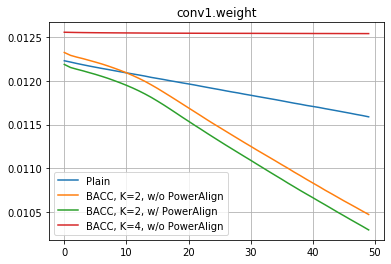

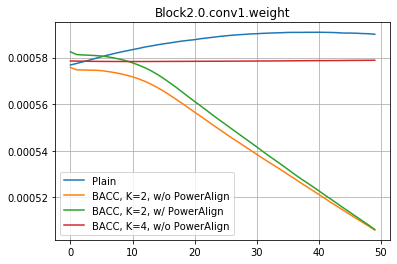

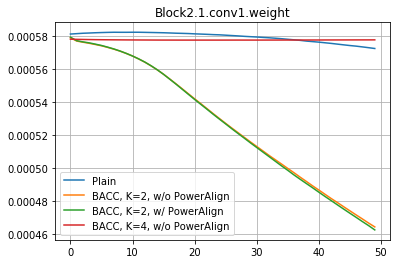

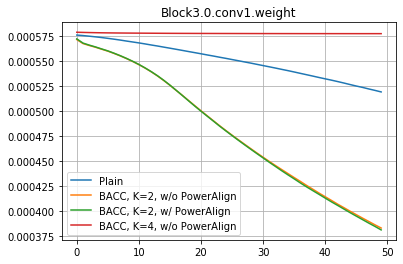

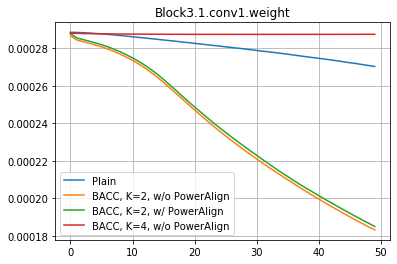

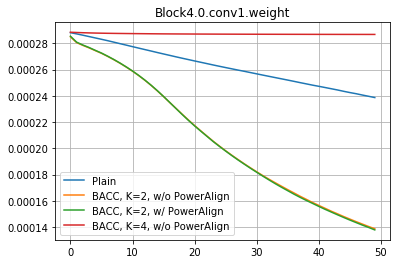

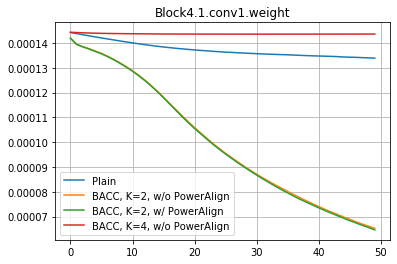

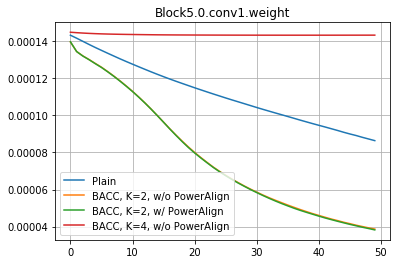

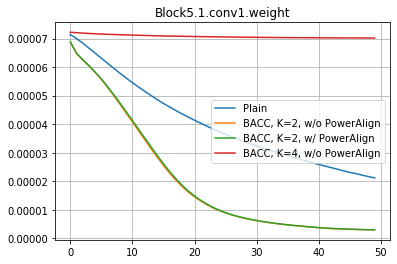

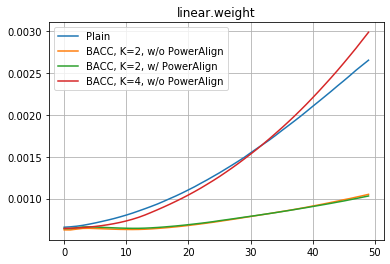

In [34]:
sel_layer = 0
for sel_layer in range(10):
    plt.title(layer_info[sel_layer])
    plt.plot(power_array_Plain_K2[:,sel_layer],label='Plain')
    plt.plot(power_array_BACC_K2_N2_noPowerAlign[:,sel_layer],label='BACC, K=2, w/o PowerAlign')
    plt.plot(power_array_BACC_K2_N2_inPowerAlign[:,sel_layer],label='BACC, K=2, w/ PowerAlign')
    plt.plot(power_array_BACC_K4_N4[:,sel_layer],label='BACC, K=4, w/o PowerAlign')
    plt.legend()
    plt.grid()
    plt.show()

# 3. Check the intermediate values

In [5]:
stt_pos = 0

end_pos = 100

images_np = encoding_input_array_np[stt_pos:end_pos,:]
if args.dataset == 'mnist':
    images_np = np.reshape(images_np, (end_pos - stt_pos,1,28,28))
else:
    images_np = np.reshape(images_np, (end_pos - stt_pos,3,32,32))
images = torch.Tensor(images_np)


if args.gpu:
    images = images.cuda()
    labels = labels.cuda()

    # wrap them in Variable
    images, labels = Variable(images), Variable(labels)

print(images)

tensor([[[[-2.4291e+00, -2.4291e+00, -2.4291e+00,  ..., -3.9365e-01,
           -8.7827e-01, -1.2272e+00],
          [-2.4291e+00, -2.4291e+00, -2.4291e+00,  ...,  4.2052e-01,
           -3.1611e-01, -9.7520e-01],
          [-2.4291e+00, -2.4291e+00, -2.4291e+00,  ...,  8.6637e-01,
           -2.1919e-01, -8.2012e-01],
          ...,
          [-2.4291e+00, -2.4291e+00, -2.4291e+00,  ...,  2.4947e+00,
            2.4172e+00,  2.4947e+00],
          [-2.4291e+00, -2.4291e+00, -2.4291e+00,  ..., -2.4291e+00,
           -2.4291e+00, -2.4291e+00],
          [-2.4291e+00, -2.4291e+00, -2.4291e+00,  ..., -2.4291e+00,
           -2.4291e+00, -2.4291e+00]],

         [[-2.4183e+00, -2.4183e+00, -2.4183e+00,  ..., -6.8757e-01,
           -9.8258e-01, -1.0809e+00],
          [-2.4183e+00, -2.4183e+00, -2.4183e+00,  ...,  2.0434e-02,
           -5.1057e-01, -8.2524e-01],
          [-2.4183e+00, -2.4183e+00, -2.4183e+00,  ...,  3.7444e-01,
           -4.7124e-01, -6.6791e-01],
          ...,
     

In [7]:
print(np.shape(input_power_array_K2_poweralign))

(50,)


In [13]:
iter = 0
input_power_array_K2_poweralign = np.zeros((5,50))
for layer_idx in range(1,6):
    print('layer_idx=',layer_idx)
    input_power_array = []
    for iter in range(50):
        _net = ResNet18()
        PATH = "./save_models/CIFAR10_ResNet18_K2_G1_T3_E50_inPowerAlign_iter"+str(iter)+".pt"
        _net.load_state_dict(torch.load(PATH))

        res18_conv = nn.Sequential(*list(_net.children())[0:layer_idx])
        res18_conv.cuda()
        w_tmp = res18_conv.state_dict()

        outputs = res18_conv(images)

    #     print(outputs.data.shape)

        tmp = torch.pow(outputs.data, 2)
        sum_ = torch.sum(tmp)

        tmp_shape = list(outputs.data.size())
        d = 1
        for i in range(len(tmp_shape)):
            d = d * tmp_shape[i]

        tmp_input_power = (sum_/d)
        # print(tmp_shape, d)
    #     print(tmp_input_power.cpu().numpy())
    #     print()

        input_power_array.append(tmp_input_power.cpu().numpy())

    input_power_array_K2_poweralign[layer_idx-1,:] = np.array(input_power_array)

layer_idx= 1
layer_idx= 2
layer_idx= 3
layer_idx= 4
layer_idx= 5


In [14]:
iter = 0
input_power_array_K4 = np.zeros((5,50))
for layer_idx in range(1,6):
    input_power_array = []
    print('layer_idx=',layer_idx)
    for iter in range(50):
        _net = ResNet18()
        PATH = "./save_models/CIFAR10_ResNet18_K4_G1_T0_N4_E50_iter"+str(iter)+".pt"
        _net.load_state_dict(torch.load(PATH))

        res18_conv = nn.Sequential(*list(_net.children())[0:layer_idx])
        res18_conv.cuda()
        w_tmp = res18_conv.state_dict()

        outputs = res18_conv(images)

    #     print(outputs.data.shape)

        tmp = torch.pow(outputs.data, 2)
        sum_ = torch.sum(tmp)

        tmp_shape = list(outputs.data.size())
        d = 1
        for i in range(len(tmp_shape)):
            d = d * tmp_shape[i]

        tmp_input_power = (sum_/d)
        # print(tmp_shape, d)
    #     print(tmp_input_power.cpu().numpy())
    #     print()

        input_power_array.append(tmp_input_power.cpu().numpy())

    input_power_array_K4[layer_idx-1,:] = np.array(input_power_array)

layer_idx= 1
layer_idx= 2
layer_idx= 3
layer_idx= 4
layer_idx= 5


In [27]:
iter = 0
input_power_array_Plain = np.zeros((5,50))
for layer_idx in range(1,6):
    print('layer_idx=',layer_idx)
    input_power_array = []
    for iter in range(50):
        _net = ResNet18()
        PATH = "./save_models/CIFAR10_ResNet18_K2_Plain_E50_iter"+str(iter)+".pt"
        _net.load_state_dict(torch.load(PATH))

        res18_conv = nn.Sequential(*list(_net.children())[0:layer_idx])
        res18_conv.cuda()
        w_tmp = res18_conv.state_dict()

        outputs = res18_conv(images)

    #     print(outputs.data.shape)

        tmp = torch.pow(outputs.data, 2)
        sum_ = torch.sum(tmp)

        tmp_shape = list(outputs.data.size())
        d = 1
        for i in range(len(tmp_shape)):
            d = d * tmp_shape[i]

        tmp_input_power = (sum_/d)
        # print(tmp_shape, d)
#         print(tmp_input_power.cpu().numpy())
#         print()

        input_power_array.append(tmp_input_power.cpu().numpy())

    input_power_array_Plain[layer_idx-1,:] = np.array(input_power_array)

layer_idx= 1
layer_idx= 2
layer_idx= 3
layer_idx= 4
layer_idx= 5


In [26]:
iter = 0
input_power_array_K2 = np.zeros((5,50))
for layer_idx in range(1,6):
    print('layer_idx=',layer_idx)
    input_power_array = []
    for iter in range(50):
        _net = ResNet18()
        PATH = "./save_models/CIFAR10_ResNet18_K2_G1_T3_E50_iter"+str(iter)+".pt"
        _net.load_state_dict(torch.load(PATH))

        res18_conv = nn.Sequential(*list(_net.children())[0:layer_idx])
        res18_conv.cuda()
        w_tmp = res18_conv.state_dict()

        outputs = res18_conv(images)

    #     print(outputs.data.shape)

        tmp = torch.pow(outputs.data, 2)
        sum_ = torch.sum(tmp)

        tmp_shape = list(outputs.data.size())
        d = 1
        for i in range(len(tmp_shape)):
            d = d * tmp_shape[i]

        tmp_input_power = (sum_/d)
        # print(tmp_shape, d)
#         print(tmp_input_power.cpu().numpy())
#         print()

        input_power_array.append(tmp_input_power.cpu().numpy())

    input_power_array_K2[layer_idx-1,:] = np.array(input_power_array)

layer_idx= 1
layer_idx= 2
layer_idx= 3
layer_idx= 4
layer_idx= 5


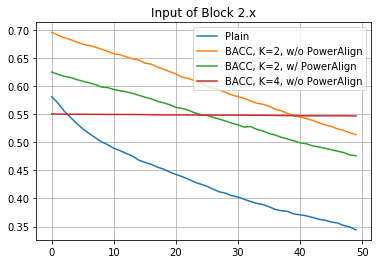

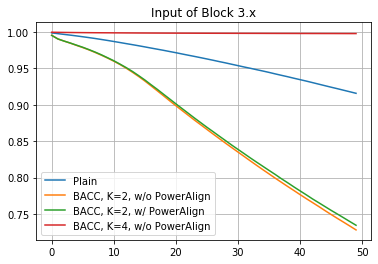

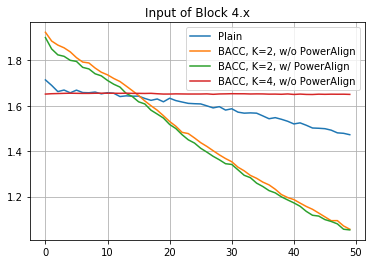

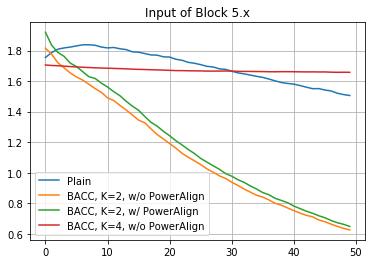

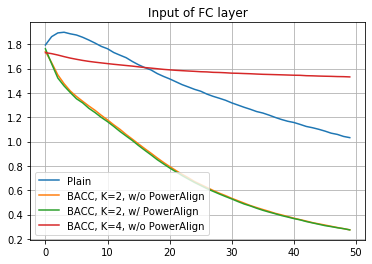

In [28]:
layer_info = ['Input of Block 2.x','Input of Block 3.x','Input of Block 4.x','Input of Block 5.x','Input of FC layer']

for layer_idx in range(5):

    # plt.title(layer_info[sel_layer])
    plt.plot(input_power_array_Plain[layer_idx,:],label='Plain')
    # plt.plot(power_array_BACC_K2_N2_noPowerAlign[:,sel_layer],label='BACC, K=2, w/o PowerAlign')
    # plt.plot(power_array_BACC_K2_N2_inPowerAlign[:,sel_layer],label='BACC, K=2, w/ PowerAlign')
    plt.plot(input_power_array_K2[layer_idx,:],label='BACC, K=2, w/o PowerAlign')
    plt.plot(input_power_array_K2_poweralign[layer_idx,:],label='BACC, K=2, w/ PowerAlign')
    plt.plot(input_power_array_K4[layer_idx,:],label='BACC, K=4, w/o PowerAlign')
#     plt.ylim([-0.2,3])
    plt.title(layer_info[layer_idx])
    plt.legend()
    plt.grid()
    plt.show()

In [37]:
acc_test_K2_plain = np.zeros(50)
for iter in range(50):
    print(iter)
    _net = ResNet18()
    _net.cuda()
    PATH = "./save_models/CIFAR10_ResNet18_K2_Plain_E50_iter"+str(iter)+".pt"
    _net.load_state_dict(torch.load(PATH))
    
    acc_test, loss_test = test_img(_net, dataset_test, args)
    acc_test_K2_plain[iter] = acc_test

0

Test set: Average loss: 1.3279 
Accuracy: 5181/10000 (51.81%)

1

Test set: Average loss: 1.0216 
Accuracy: 6355/10000 (63.55%)

2

Test set: Average loss: 0.8823 
Accuracy: 6833/10000 (68.33%)

3

Test set: Average loss: 0.7931 
Accuracy: 7193/10000 (71.93%)

4

Test set: Average loss: 0.7038 
Accuracy: 7569/10000 (75.69%)

5

Test set: Average loss: 0.6571 
Accuracy: 7703/10000 (77.03%)

6

Test set: Average loss: 0.6193 
Accuracy: 7847/10000 (78.47%)

7

Test set: Average loss: 0.5851 
Accuracy: 7991/10000 (79.91%)

8

Test set: Average loss: 0.5680 
Accuracy: 8059/10000 (80.59%)

9

Test set: Average loss: 0.5292 
Accuracy: 8180/10000 (81.80%)

10

Test set: Average loss: 0.5023 
Accuracy: 8299/10000 (82.99%)

11

Test set: Average loss: 0.4929 
Accuracy: 8326/10000 (83.26%)

12

Test set: Average loss: 0.4811 
Accuracy: 8358/10000 (83.58%)

13

Test set: Average loss: 0.4664 
Accuracy: 8443/10000 (84.43%)

14

Test set: Average loss: 0.4455 
Accuracy: 8495/10000 (84.95%)

15

T

In [42]:
import pickle
filehandler = open("./plot/CIFAR10_ResNet18_K2_Plain_E50_test_acc","wb")
pickle.dump(acc_test_K2_plain,filehandler)


In [40]:
acc_test_BACC_K2_withoutBN = np.zeros(50)
for iter in range(50):
    print(iter)
    _net = ResNet18()
    _net.cuda()
    PATH = "./save_models/CIFAR10_ResNet18_K2_G1_T3_E50_iter"+str(iter)+".pt"
    _net.load_state_dict(torch.load(PATH))
    
    acc_test, loss_test = test_img(_net, dataset_test, args)
    acc_test_BACC_K2_withoutBN[iter] = acc_test

0

Test set: Average loss: 1.8893 
Accuracy: 3477/10000 (34.77%)

1

Test set: Average loss: 1.8361 
Accuracy: 3860/10000 (38.60%)

2

Test set: Average loss: 1.8261 
Accuracy: 3930/10000 (39.30%)

3

Test set: Average loss: 1.8565 
Accuracy: 3794/10000 (37.94%)

4

Test set: Average loss: 1.8649 
Accuracy: 3803/10000 (38.03%)

5

Test set: Average loss: 1.8773 
Accuracy: 3793/10000 (37.93%)

6

Test set: Average loss: 1.8755 
Accuracy: 3760/10000 (37.60%)

7

Test set: Average loss: 1.9108 
Accuracy: 3696/10000 (36.96%)

8

Test set: Average loss: 1.8739 
Accuracy: 3842/10000 (38.42%)

9

Test set: Average loss: 1.8894 
Accuracy: 3744/10000 (37.44%)

10

Test set: Average loss: 1.8874 
Accuracy: 3760/10000 (37.60%)

11

Test set: Average loss: 1.8667 
Accuracy: 3902/10000 (39.02%)

12

Test set: Average loss: 1.8644 
Accuracy: 3884/10000 (38.84%)

13

Test set: Average loss: 1.8687 
Accuracy: 3826/10000 (38.26%)

14

Test set: Average loss: 1.8847 
Accuracy: 3792/10000 (37.92%)

15

T

In [43]:
import pickle
filehandler = open("./plot/CIFAR10_ResNet18_BACC_K2_N2_E50_withoutBN_test_acc","wb")
pickle.dump(acc_test_BACC_K2_withoutBN,filehandler)

In [44]:
acc_test_BACC_K4_withoutBN = np.zeros(50)
for iter in range(50):
    print(iter)
    _net = ResNet18()
    _net.cuda()
    PATH = "./save_models/CIFAR10_ResNet18_K4_G1_T0_N4_E50_iter"+str(iter)+".pt"
    _net.load_state_dict(torch.load(PATH))
    
    acc_test, loss_test = test_img(_net, dataset_test, args)
    acc_test_BACC_K4_withoutBN[iter] = acc_test

0

Test set: Average loss: 1.8070 
Accuracy: 3367/10000 (33.67%)

1

Test set: Average loss: 1.6801 
Accuracy: 3883/10000 (38.83%)

2

Test set: Average loss: 1.6194 
Accuracy: 4109/10000 (41.09%)

3

Test set: Average loss: 1.5866 
Accuracy: 4238/10000 (42.38%)

4

Test set: Average loss: 1.5691 
Accuracy: 4260/10000 (42.60%)

5

Test set: Average loss: 1.5602 
Accuracy: 4284/10000 (42.84%)

6

Test set: Average loss: 1.5614 
Accuracy: 4307/10000 (43.07%)

7

Test set: Average loss: 1.5798 
Accuracy: 4228/10000 (42.28%)

8

Test set: Average loss: 1.6056 
Accuracy: 4175/10000 (41.75%)

9

Test set: Average loss: 1.6477 
Accuracy: 4084/10000 (40.84%)

10

Test set: Average loss: 1.6987 
Accuracy: 4014/10000 (40.14%)

11

Test set: Average loss: 1.7670 
Accuracy: 3947/10000 (39.47%)

12

Test set: Average loss: 1.8418 
Accuracy: 3894/10000 (38.94%)

13

Test set: Average loss: 1.9119 
Accuracy: 3879/10000 (38.79%)

14

Test set: Average loss: 1.9970 
Accuracy: 3823/10000 (38.23%)

15

T

In [45]:
class my_argument:    
    epochs    = 16    #"rounds of training"
    num_users = 4  # "number of users: K"
    frac      = 0.5 #"the fraction of clients: C"
    local_ep  = 1 #"the number of local epochs: E"
    local_bs  = 50  #"local batch size: B"
    bs        = 50 #"test batch size"
    lr        = 0.001 #"learning rate"
    momentum  = 0.5 # "SGD momentum (default: 0.5)"
    weight_decay = 5e-4
    split     = 'user' # "train-test split type, user or sample"
    opt='ADAM'
    loss='Custom' # 'Custom' or 'Default'

    # model arguments
    model = 'cnn'
    kernel_num=9 #, help='number of each kind of kernel')
    kernel_sizes='3,4,5' #  help='comma-separated kernel size to use for convolution')
    norm='batch_norm' #, help="batch_norm, layer_norm, or None")
    num_filters=32 #, help="number of filters for conv nets")
    max_pool='True' #help="Whether use max pooling rather than strided convolutions")

    # other arguments
    dataset='cifar' #, help="name of dataset")
    iid=1
    num_classes=10#, help="number of classes")
    num_channels=1#, help="number of channels of imges")
    gpu=1#, help="GPU ID, -1 for CPU")
    stopping_rounds=10#, help='rounds of early stopping')
    verbose='False'#, help='verbose print')
    seed=1#, help='random seed (default: 1)')
    
args = my_argument()

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

use_cuda = torch.cuda.is_available()
print(use_cuda)
args.device = torch.device("cuda" if use_cuda else "cpu")
print(args.device)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# trainset = torchvision.datasets.CIFAR10(
#     root="./data/cifar", train=True, download=True, transform=transform_train)
# trainloader = torch.utils.data.DataLoader(
#     trainset, batch_size=args.bs, shuffle=True, num_workers=2)

# testset = torchvision.datasets.CIFAR10(
#     root="./data/cifar", train=False, download=True, transform=transform_test)
# testloader = torch.utils.data.DataLoader(
#     testset, batch_size=args.bs, shuffle=False, num_workers=2)

dataset_train = datasets.CIFAR10('../data/cifar', train=True, download=True, transform=transform_train)
dataset_test = datasets.CIFAR10('../data/cifar', train=False, download=True, transform=transform_test)
if args.iid:
    dict_users = cifar_iid(dataset_train, args.num_users)

True
cuda
Files already downloaded and verified
Files already downloaded and verified


In [46]:
encoding_input_array_np = np.empty((len(dataset_train),32*32*3))
encoding_label_array_np = np.empty((len(dataset_train),args.num_classes))
print("size of X:" ,encoding_input_array_np.shape)
print("size of Y:" ,encoding_label_array_np.shape)

Size_submatrices = int(50000/args.num_users)


for i in range(args.num_users):
    
    stt_pos = i*Size_submatrices
    end_pos = (i+1)*Size_submatrices
#     print(i,stt_pos,end_pos)
    Temp_train = DataLoader(DatasetSplit(dataset_train, dict_users[i]), batch_size=Size_submatrices, shuffle=True)
    
    for batch_idx, (images, labels) in enumerate(Temp_train):
        
        images_np = images.detach().cpu().numpy()
        
#         print(np.size(images_np))
        encoding_input_array_np[stt_pos:end_pos,:] = np.reshape(images_np, (Size_submatrices,32*32*3))
#         print(encoding_input_array_np[stt_pos:end_pos,:].shape)

        onehot_labels = torch.nn.functional.one_hot(labels,num_classes=args.num_classes)
        labels_np = onehot_labels.detach().cpu().numpy()
#         print(labels_np.shape)
        encoding_label_array_np[stt_pos:end_pos,:] = labels_np
    
print(np.shape(encoding_label_array_np))

size of X: (50000, 3072)
size of Y: (50000, 10)
(50000, 10)


In [48]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

K = 4
T = 0
sigma = 0.1
Noise_Alloc = []

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))

# alpha_array = np.array([-0.57, 0.57])
# print("alpha_array: ",alpha_array,'\n')

B = 0.5


N_array = [4]
B_array = [0.5]

N_trials = 1
N_epochs = 50

lr_array = [0.0001] # 0.001 is the bset

sigma_array = [1]
# lr_array = [0.1, 0.01, 0.005, 0.001,0.0005]


loss_test_arr_K4_G1_T0 = np.zeros((len(N_array),len(lr_array),N_trials,N_epochs))
acc_test_arr_K4_G1_T0  = np.zeros((len(N_array),len(lr_array),N_trials,N_epochs))


for N_idx in range(len(N_array)):
    
    N = N_array[N_idx]
    
    print('\n\n')
    print('N =',N)
    print('\n\n')
           
        
    # print("alpha_array: ",alpha_array,'\n')
    
    
    for lr_idx in range(len(lr_array)):
        
        args.lr = lr_array[lr_idx]
        
        print('Learning Rate =',args.lr)
        print('\n\n')
#         while(len(z_array)<N):
#             z_tmp = np.random.uniform(-1,1,1)
#             MIS_tmp = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_tmp], 1,sigma)
#             if MIS_tmp < B and MIS_tmp > 0.1:
#                 z_array.append(z_tmp[0])
#         
#         z_array = np.sort(z_array)
#         print(N_idx,'!!!')
#         if N_idx==0:
# #             z_array = np.array([-0.94,-0.534,0.534, 0.94])
# #         elif N_idx==1:
# #             z_array = np.array([-0.94, -0.73, 0.73, 0.94])
#         elif N_idx==1:
#             z_array = np.array([-0.94, -0.125, 0.125, 0.94])
#         else:
# #             z_array = np.array([-0.94, -0.73, -0.534, -0.125, 0.125, 0.534, 0.73, 0.94])
# #             z_array = np.array([-0.9, -0.81, -0.22, -0.20, 0.20, 0.22, 0.81, 0.9])
        
#         z_array = np.array([-0.81, 0.81])
        
        i_array = np.array(range(N))
        z_array = np.cos(i_array*2*math.pi/N/2) # np.cos(i_array*2*math.pi/N/2)
        
        print('z_array:',z_array)
#         if sigma != 0:
#             for j in range(len(z_array)):
#                 print(MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,sigma))

        
        _Noise_label = np.ones((25000*T,10)) * 0.1

        X_tilde,a,b = BACC_Enc_Data_v3(encoding_input_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde,a,b = BACC_Enc_Data_v3(encoding_label_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)
        
        print("Adjust the power of X_tilde")
        
        for p_idx in range(N):
            tmp_power = np.sum(X_tilde[p_idx,:,:] * X_tilde[p_idx,:,:], axis=1)/np.shape(X_tilde)[2]
            tmp_power = np.sum(tmp_power)/np.shape(X_tilde)[1]
            print(p_idx, tmp_power)
            
            X_tilde[p_idx,:,:] = X_tilde[p_idx,:,:] * np.sqrt(avg_power/tmp_power)
            tmp_power = np.sum(X_tilde[p_idx,:,:] * X_tilde[p_idx,:,:], axis=1)/np.shape(X_tilde)[2]
            tmp_power = np.sum(tmp_power)/np.shape(X_tilde)[1]
            print('power after adjusting =',tmp_power)
        print()
        
        m = N # m is the number of received result @ master
    #     print('number of results:',m)

        for trial_idx in range(N_trials):
            print('(T, sigma)=',T,sigma,') ',trial_idx,'-th Trial!!')

            net_glob = ResNet18()
            net_glob.cuda()
            net_glob.train()

            # copy weights
            w_glob = net_glob.state_dict()

            for iter in range(N_epochs): #args.epochs
                w_locals, loss_locals = [], []
                idxs_users = np.random.choice(range(N), m, replace=False)
                idxs_users = np.sort(idxs_users)
                print('selected users:',idxs_users)
                
#                 coded_net = BACC_Enc_Model_withNoise_v4(net_glob.cuda(), N, K, T, sigma, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

                dec_z_array = []
                for idx in idxs_users: #for idx in range(N):
            #         print(idx)
                    local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
#                     w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
                    w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))

                    dec_z_array.append(z_array[idx])


                # update global weights
                #w_glob = FedAvg(w_locals)
                w_glob = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
            #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

            #     loss_train_arr.append(loss_train)

                acc_test, loss_test = test_img(net_glob, dataset_test, args)
                acc_test_arr_K4_G1_T0[N_idx][lr_idx][trial_idx][iter] = acc_test
                loss_test_arr_K4_G1_T0[N_idx][lr_idx][trial_idx][iter] = loss_test
                if iter % 1 ==0:
                    print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
                #print(loss_train)
                
                PATH = "./save_models/CIFAR10_ResNet18_K4_G1_T0_N"+str(N)+"_inPowerAlign_E50_iter"+str(iter)+".pt"
                torch.save(net_glob.state_dict(), PATH)




N = 4



Learning Rate = 0.0001



z_array: [ 1.00000000e+00  7.07106781e-01  6.12323400e-17 -7.07106781e-01]
@BACC_Enc: N,K,T, m_i= 4 4 0 12500 

@BACC_Enc: N,K,T, m_i= 4 4 0 12500 

Adjust the power of X_tilde
0 2.5763280173536156
power after adjusting = 2.073926868059394
1 1.3327710157556738
power after adjusting = 2.0739268680593934
2 3.3568425517238456
power after adjusting = 2.073926868059394
3 1.3239796019249381
power after adjusting = 2.073926868059393

(T, sigma)= 0 0.1 )  0 -th Trial!!
selected users: [0 1 2 3]

Test set: Average loss: 1.8497 
Accuracy: 3542/10000 (35.42%)

Round   0, Average loss 1.850 Test accuracy 35.420
selected users: [0 1 2 3]

Test set: Average loss: 1.6664 
Accuracy: 4059/10000 (40.59%)

Round   1, Average loss 1.666 Test accuracy 40.590
selected users: [0 1 2 3]

Test set: Average loss: 1.5668 
Accuracy: 4716/10000 (47.16%)

Round   2, Average loss 1.567 Test accuracy 47.160
selected users: [0 1 2 3]

Test set: Average loss: 1.5192 
Accuracy: 5007